In [1]:
# House Price Prediction In Egypt

In [2]:
# Load the dataset 

import pandas as pd

df = pd.read_csv("Egypt_Houses_Price.csv")

In [4]:
df.head()

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City
0,Duplex,4000000,3.0,3.0,400.0,No,7,Unknown,Cash,Ready to move,Finished,Nasr City
1,Apartment,4000000,3.0,3.0,160.0,No,10+,Unknown,Cash,Ready to move,Finished,Camp Caesar
2,Apartment,2250000,3.0,2.0,165.0,No,1,Unknown,Cash,Ready to move,Finished,Smoha
3,Apartment,1900000,3.0,2.0,230.0,No,10,Unknown,Cash,Ready to move,Finished,Nasr City
4,Apartment,5800000,2.0,3.0,160.0,No,Ground,Eastown,Cash,Ready to move,Semi Finished,New Cairo - El Tagamoa


In [5]:
# Data exploration

df.describe()

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City
count,27361,27359,27158,27190,26890,27361,27361,27361,27361,27361,27361,27361
unique,11,4182,22,22,1073,3,14,560,4,10,5,183
top,Apartment,3000000,3,2,120.0,No,Unknown,Unknown,Cash or Installment,Ready to move,Finished,New Cairo - El Tagamoa
freq,8506,311,9784,7753,663,16500,10439,11068,10842,12142,14375,6789


In [6]:
# Check the type and the missing data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27361 entries, 0 to 27360
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Type            27361 non-null  object
 1   Price           27359 non-null  object
 2   Bedrooms        27158 non-null  object
 3   Bathrooms       27190 non-null  object
 4   Area            26890 non-null  object
 5   Furnished       27361 non-null  object
 6   Level           27361 non-null  object
 7   Compound        27361 non-null  object
 8   Payment_Option  27361 non-null  object
 9   Delivery_Date   27361 non-null  object
 10  Delivery_Term   27361 non-null  object
 11  City            27361 non-null  object
dtypes: object(12)
memory usage: 2.5+ MB


In [7]:
# Data cleaning

import numpy as np

# Replace specific values in the 'Level' column with numerical values.
df['Level'] = df['Level'].replace({'Unknown': 0, 'Ground': 0, '10+': 10, 'Highest': 11})

# Convert object types to numerical 
for c in ['Area', 'Bedrooms', 'Bathrooms', 'Level',"Price"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Adjust the 'Price' column by adding 3,000,000 to account for inflation
df['Price'] += 3000000 



In [8]:
#Filling NUll values with mean, is better than removing it
df["Area"] = df["Area"].fillna(df["Area"].mean())
df["Bedrooms"] = df["Bedrooms"].fillna(df["Bedrooms"].mean())
df["Bathrooms"] = df["Bathrooms"].fillna(df["Bathrooms"].mean())
df["Price"] = df["Price"].fillna(df["Price"].mean())

#  Create a new column 'Price_log' to store the logarithm of the "Price" to use in visualization, as "Price" is large.
df['Price_log'] = np.log1p(df['Price'])


In [9]:
# Filter out the outliers
df['price_per_m2'] = df['Price'] / df['Area']

# Set a threshold for what is considered a reasonable price per square meter
upper_threshold = df['price_per_m2'].quantile(0.85)  
lower_threshold = df['price_per_m2'].quantile(0.05)

# Filter out outliers where the price per square meter is too high
df_cleaned = df[(df['price_per_m2'] < upper_threshold) & (df['price_per_m2'] > lower_threshold)]

df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 21882 entries, 0 to 27360
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Type            21882 non-null  object 
 1   Price           21882 non-null  float64
 2   Bedrooms        21882 non-null  float64
 3   Bathrooms       21882 non-null  float64
 4   Area            21882 non-null  float64
 5   Furnished       21882 non-null  object 
 6   Level           21882 non-null  int64  
 7   Compound        21882 non-null  object 
 8   Payment_Option  21882 non-null  object 
 9   Delivery_Date   21882 non-null  object 
 10  Delivery_Term   21882 non-null  object 
 11  City            21882 non-null  object 
 12  Price_log       21882 non-null  float64
 13  price_per_m2    21882 non-null  float64
dtypes: float64(6), int64(1), object(7)
memory usage: 2.5+ MB


In [10]:
# Define the feature matrix (x) and target variable (y):

x = df_cleaned[["Type","Area","Bedrooms","Bathrooms","Level","Furnished","City"]] # Independent Variables (Features or Predictors)
y = df_cleaned["Price"] # Dependent Variable (Target or Output Variable)

# Create a copy of X to avoid potential issues with modifying a slice of the original DataFrame
X = x.copy()

In [13]:
from sklearn.preprocessing import LabelEncoder

# Convert non-numeric categorical columns into numeric values using Label Encoding
# LabelEncoder assigns a unique numeric label (integer) to each category in the column.

# Encode 'Type' column (e.g., Apartment, Duplex, etc.) into numeric labels
label_type = LabelEncoder()
X["Type"] = label_type.fit_transform(X["Type"])

# Encode 'Furnished' column (Yes/No) into numeric labels
label_furnished = LabelEncoder()
X["Furnished"] = label_furnished.fit_transform(X["Furnished"])

# Encode 'City' column (different cities) into numeric labels
label_city = LabelEncoder()
X["City"] = label_city.fit_transform(X["City"])

# Convert object types to numerical 
for c in ['Type', 'Furnished', 'City']:
    X[c] = pd.to_numeric(X[c], errors="coerce")


In [14]:
# Training the data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


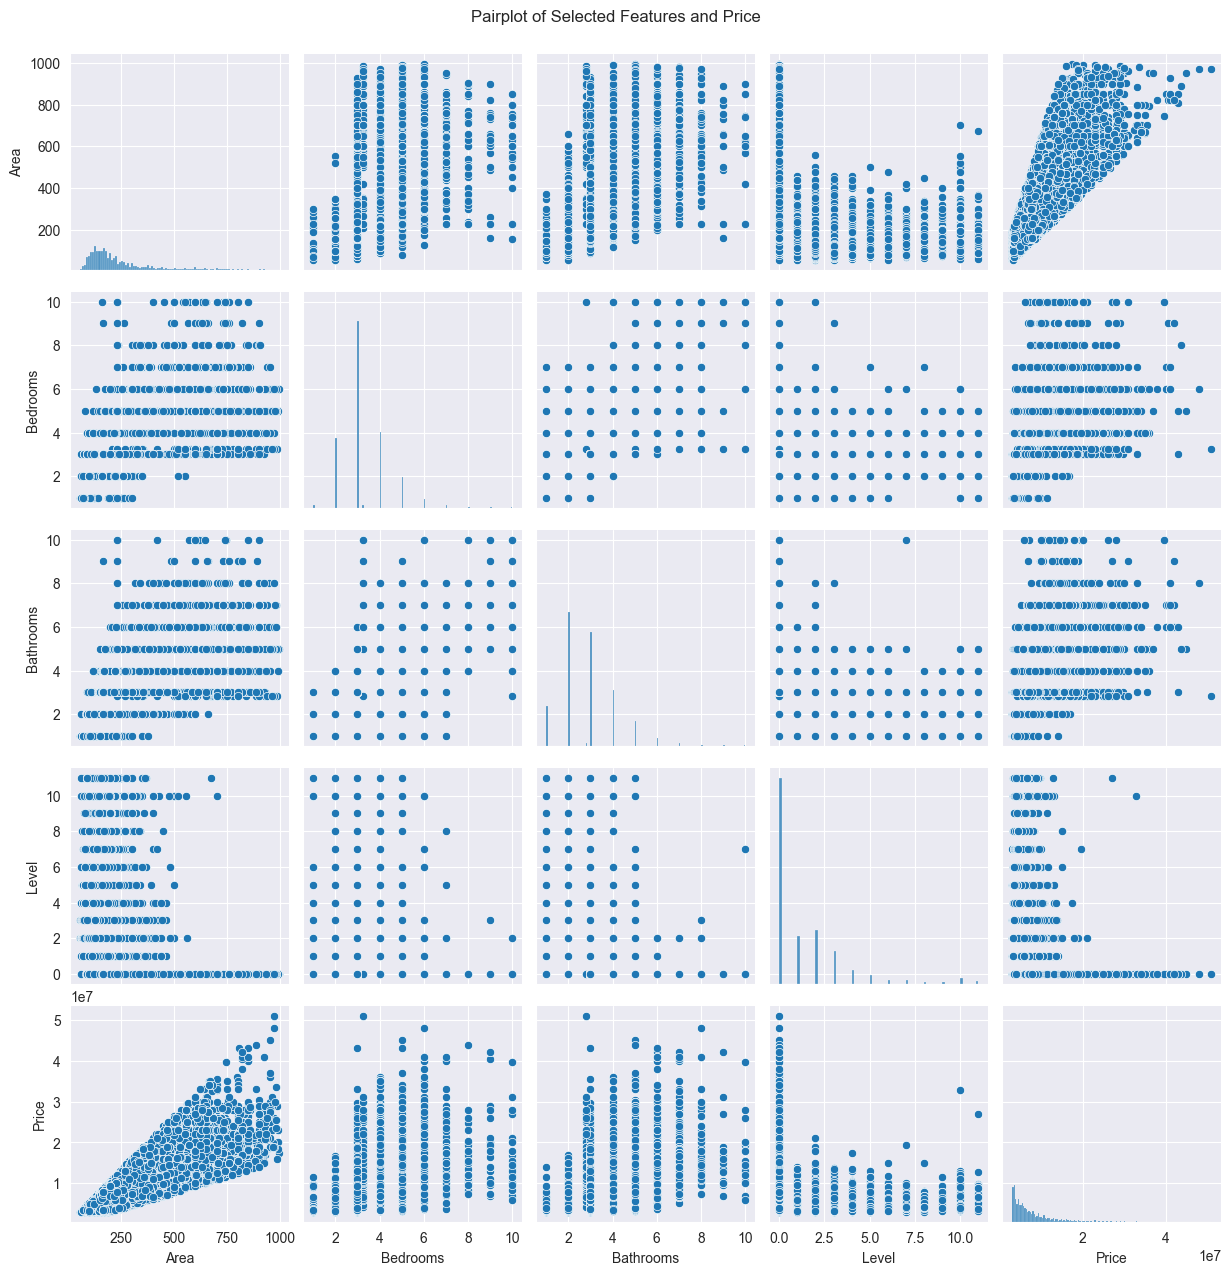

In [15]:
# Data Visualization

import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target variable into a single DataFrame
data_combined = pd.concat([X, y], axis=1) 

# Select the specific columns to visualize
columns_to_plot = ['Area', 'Bedrooms', 'Bathrooms', 'Level', 'Price']
data_subset = data_combined[columns_to_plot]

# Use pairplot
sns.pairplot(data_subset)
plt.suptitle('Pairplot of Selected Features and Price', y=1.02) 
plt.show()

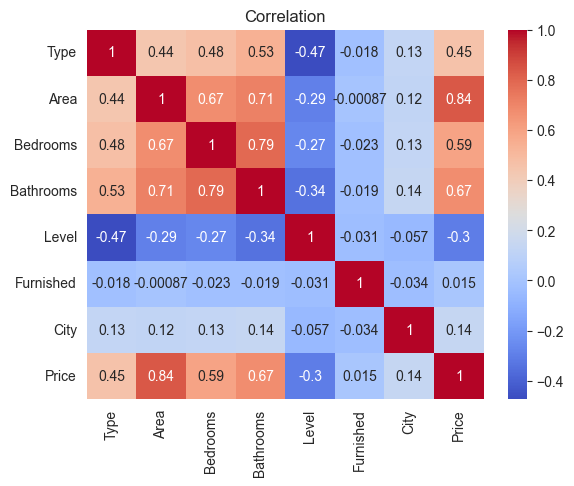

In [16]:
# Generate a correlation matrix

corr_matrix = data_combined.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation')
plt.show()

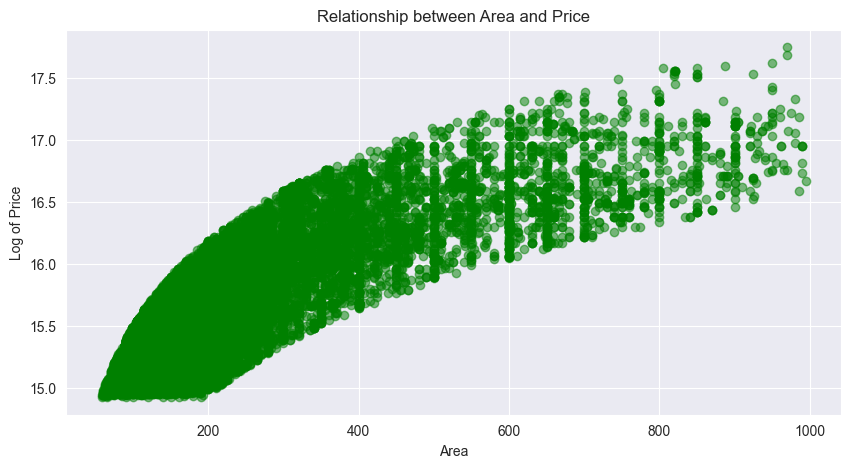

In [17]:
# Plot relationship between Area and Log Of Price

plt.figure(figsize=(10, 5))
plt.scatter(X['Area'], df_cleaned["Price_log"], alpha=.5, c="g")  
plt.title('Relationship between Area and Price')
plt.xlabel('Area')
plt.ylabel('Log of Price')
plt.show()



In [18]:
# Modeling the data using Linear Regression

from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_test, y_test))
y1_pred = lm.predict(X_test)

0.7188099283200091


In [20]:
# Evaluate the model using Polynomial Regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lm.fit(X_train_poly, y_train)
print(lm.score(X_test_poly, y_test))
y2_pred = lm.predict(X_test_poly)

0.7262330734042883


In [21]:
# Evaluate the model using Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()
forest.fit(X_train, y_train)
print(forest.score(X_test,y_test))
y3_pred = forest.predict(X_test)

0.7791134966842057


In [22]:
# Calculate the mean absolute error score for each model to determine which model best.

from sklearn.metrics import mean_absolute_error



mae1 = mean_absolute_error(y_test, y1_pred)
print(f'Mean Absolute Error (MAE) using Linear Regression: {mae1:.4f}')

print(f'-----------------------------------------')

mae2 = mean_absolute_error(y_test, y2_pred)
print(f'Mean Absolute Error (MAE) using Polynomial Features: {mae2:.4f}')

print(f'-----------------------------------------')

mae3 = mean_absolute_error(y_test, y3_pred)
print(f'Mean Absolute Error (MAE) using Random Forest: {mae3:.4f}')



Mean Absolute Error (MAE) using Linear Regression: 1728059.0479
-----------------------------------------
Mean Absolute Error (MAE) using Polynomial Features: 1682491.4126
-----------------------------------------
Mean Absolute Error (MAE) using Random Forest: 1333377.3434


In [23]:
# Create a function to get the data from the user about their property, validate the input, and prepares the data for a prediction model.

def get_user_input():
    print("Please enter the following details for your property:")

    # Validate type input to prevent any error while input the data
    valid_property_types = ['Apartment', 'Duplex', 'Stand Alone Villa', 'Chalet']
    while True:
        property_type = input("Type (Apartment, Duplex, Stand Alone Villa, Chalet): ")
        if property_type in valid_property_types:
            break
        else:
            print("Please enter a valid property type.")
    
    # Validate area input
    # try: to handle that area is not a string
    # if: to ensure that area is a positive value
    while True:
        try:
            area = float(input("Area (in square meters): "))
            if area > 0:
                break
            else:
                print("Area should be a positive number.")
        except ValueError:
            print("Please enter a valid number for the area.")
    
    # Validate bedrooms input 
    while True:
        try:
            bedrooms = int(input("Number of Bedrooms: "))
            if bedrooms >= 0:
                break
            else:
                print("Number of bedrooms should be a non-negative integer.")
        except ValueError:
            print("Please enter a valid integer for the number of bedrooms.")
    
    # Validate bathrooms input
    while True:
        try:
            bathrooms = int(input("Number of Bathrooms: "))
            if bathrooms >= 0:
                break
            else:
                print("Number of bathrooms should be a non-negative integer.")
        except ValueError:
            print("Please enter a valid integer for the number of bathrooms.")
    
    # Validate level input
    valid_levels = ['Ground', '1', '2', '10+']
    while True:
        level = input("Level (Ground, 1, 2, 10+): ")
        if level in valid_levels or (level.isdigit() and int(level) > 0):
            break
        else:
            print("Please enter a valid level (Ground, 1, 2, 10+).")
    
    # Validate furnished input
    furnished = input("Furnished (Yes or No): ")
    furnished = 'Yes' if furnished == 'yes' else 'No'
    
    # Validate city input
    city = input("City (New Cairo - El Tagamoa | North Coast | Sheikh Zayed | 6th of October | Ain Sukhna): ")
    
    # Matching the input with the dataframe 
    new_data = pd.DataFrame({
        'Type': [property_type],
        'Area': [area],
        'Bedrooms': [bedrooms],
        'Bathrooms': [bathrooms],
        'Level': [level],
        'Furnished': [furnished],
        'City': [city]
    })
    
    # Preprocess new data (encoders are defined earlier in the code)
    new_data['Level'] = new_data['Level'].replace({'Ground': 0, '10+': 10})
    new_data['Type'] = label_type.transform(new_data['Type'])
    new_data['Furnished'] = label_furnished.transform(new_data['Furnished'])
    new_data['City'] = label_city.transform(new_data['City'])
    
    # Make prediction
    prediction = forest.predict(new_data)
    print(f"The predicted price for the property is: {prediction[0]:,.2f} EGP")




    

# Run the function
get_user_input()

Please enter the following details for your property:
The predicted price for the property is: 4,920,480.00 EGP
